In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 40.0 MB/s 
     |████████████████████████████████| 596 kB 66.2 MB/s 
     |████████████████████████████████| 101 kB 13.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from transformers import TFBertForSequenceClassification, InputExample, InputFeatures, TFBertModel
import tensorflow as tf

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sentiment analysis/Copy of Reviews.csv')

In [ ]:
train = df[75000:80000]
validation = df[250000:251000]
test = df[251000:252000]

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
inp_ids = keras.Input(shape = (None,), dtype = "int32", name="input_ids")
att_mask = keras.Input(shape = (None,), dtype = "int32", name="attention_mask")
tok_ids = keras.Input(shape = (None,), dtype = "int32", name="token_type_ids")
x = TFBertModel.from_pretrained('bert-base-uncased')([inp_ids, att_mask, tok_ids]).pooler_output
x = layers.Dropout(0.5)(x)
out = layers.Dense(2, activation="softmax")(x)

mod = keras.Model(
    [att_mask, inp_ids, tok_ids], out, name="Classifier"
)
mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6, epsilon=1e-8),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"]
)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
mod.summary()

Model: "Classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def convert_data_to_examples(train, validation): 
      train_InputExamples = train.apply(lambda x: InputExample(guid=None, 
                                                          text_a = x['Text'], 
                                                          text_b = None,
                                                          label = 1 if x["Score"] > 3 else 0), axis = 1)

      validation_InputExamples = validation.apply(lambda x: InputExample(guid=None,
                                                          text_a = x["Text"], 
                                                          text_b = None,
                                                          label = 1 if x["Score"] > 3 else 0), axis = 1)
  
      return train_InputExamples, validation_InputExamples

  
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, validation)


In [ ]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = []

    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, 
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(InputFeatures(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label))

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


In [ ]:
BATCH_SIZE = 16
MAX_LEN = 256

train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer, MAX_LEN)
train_data = train_data.shuffle(100).batch(BATCH_SIZE)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
mod.fit(train_data, epochs=6, validation_data=validation_data)

Epoch 1/6
313/313 [==============================] - 299s 862ms/step - loss: 0.6127 - accuracy: 0.7134 - val_loss: 0.5365 - val_accuracy: 0.7400
Epoch 2/6
313/313 [==============================] - 271s 866ms/step - loss: 0.4927 - accuracy: 0.7760 - val_loss: 0.4467 - val_accuracy: 0.7850
Epoch 3/6
313/313 [==============================] - 271s 867ms/step - loss: 0.4100 - accuracy: 0.8156 - val_loss: 0.4017 - val_accuracy: 0.8220
Epoch 4/6
313/313 [==============================] - 275s 880ms/step - loss: 0.3576 - accuracy: 0.8382 - val_loss: 0.3426 - val_accuracy: 0.8670
Epoch 5/6
313/313 [==============================] - 277s 884ms/step - loss: 0.3148 - accuracy: 0.8656 - val_loss: 0.3334 - val_accuracy: 0.8720
Epoch 6/6
313/313 [==============================] - 277s 884ms/step - loss: 0.2775 - accuracy: 0.8844 - val_loss: 0.3314 - val_accuracy: 0.8700


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6, epsilon=1e-08), 
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=5, validation_data=validation_data)

Epoch 1/5
313/313 [==============================] - 297s 892ms/step - loss: 0.5341 - accuracy: 0.7702 - val_loss: 0.5575 - val_accuracy: 0.7360
Epoch 2/5
313/313 [==============================] - 280s 893ms/step - loss: 0.4497 - accuracy: 0.7936 - val_loss: 0.3856 - val_accuracy: 0.8370
Epoch 3/5
313/313 [==============================] - 280s 893ms/step - loss: 0.3067 - accuracy: 0.8752 - val_loss: 0.3285 - val_accuracy: 0.8790
Epoch 4/5
313/313 [==============================] - 280s 893ms/step - loss: 0.2553 - accuracy: 0.8974 - val_loss: 0.3019 - val_accuracy: 0.8870
Epoch 5/5
313/313 [==============================] - 279s 893ms/step - loss: 0.2234 - accuracy: 0.9150 - val_loss: 0.3015 - val_accuracy: 0.8910


In [ ]:
pred_sentences = []
review = []
score = []
for e in test['Text']:
    pred_sentences.append(e)

for e in test['Score']:
    review.append(1 if e>3 else 0)
    score.append(e)

In [ ]:
corr = 0
preds = []
for j in range(0,1000,BATCH_SIZE):   
    temp = pred_sentences[j:j+BATCH_SIZE]
    tf_batch = tokenizer(temp, max_length=MAX_LEN, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = mod(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs, axis=-1)
    labels = ['Negative','Positive']
    label = tf.argmax(tf_predictions, axis=1)
    label = label.numpy()
    preds.extend(label)
    for i in range(len(temp)):
        #print(pred_sentences[i+j], ": \n", labels[label[i]], score[i+j])
        if(label[i] == review[i+j]):
            corr += 1
        else:
            pass
         #   print("\n\n")
print("Test Accuracy : {}".format(corr/len(pred_sentences)))

Test Accuracy : 0.884


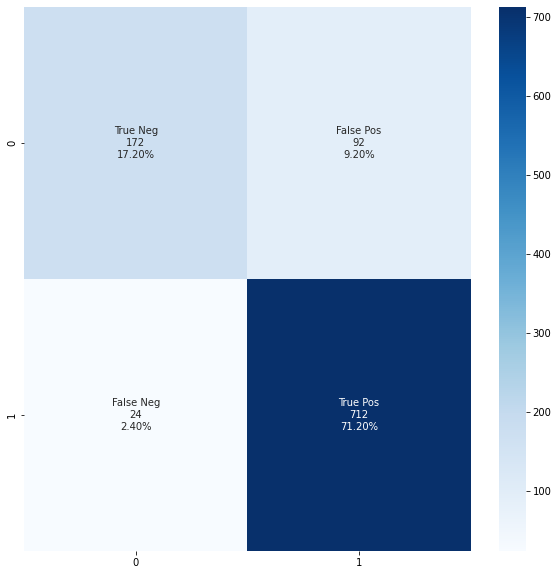

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
cf_matrix = confusion_matrix(review, preds)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=ax)

In [ ]:
#model.save('/content/drive/MyDrive/Colab Notebooks/sentiment analysis/5epoch16batch256len')
#model.load_weights('/content/drive/MyDrive/Colab Notebooks/sentiment analysis/1epoch16batch256len')

# Batch size    Epochs    Max Len     lr     Acc

#   32            2         128      3e-5    89.0

#   16            2         256      3e-5    89.5

#   6             2         512      3e-5    89.1

#   16            2         256      5e-5    88.1

#   16            5         256      1e-6    90.5
